# Analyse and visualise USDT (Tether) transactions
[Data](https://s3-us-west-2.amazonaws.com/data.blockspur.com/tether/tether_transactions_522647.csv.zip) and idea [from a project](https://rstudio-pubs-static.s3.amazonaws.com/381106_66dadeefc9094bda99099c51a6c6a6e1.html). Bit outdated but the principle remains.

I have looked at 2014-2018 transaction data of the USDT (Tether) blockchain. 

Network structure shows clusters with lots of activities that are mostly exchanges when matching to the Tether rick list wallet addresses. The network is not well connected and the average degree is 2, no matter if we look at it as directed or undirected graph. 

From the data we can estimate the wallet size and find that the exchanges have the largest amount of Tether in their wallets whereas the Tether treasury has a negative estimated balance sending more coins than recieving. From this we could try and match the large wallets to other exchanges.

Furthermore, the adoption of Tether over time can be seen from an increase in transaction volume as well as the amount sent per transaction. 

Next steps would be to perform more network statistics which are computational expensive and not possible in this project.

In [104]:
import pandas as pd
import networkx as nx
import datetime as dt

import matplotlib.pyplot as plt
from pyvis.network import Network
import seaborn as sns

In [301]:
def plot_network(data,source,target,weight):

    net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white',notebook=True,directed=True)

    # set the physics layout of the network
    net.barnes_hut()
    
    sources = data[source]
    targets = data[target]
    weights = data[weight]

    edge_data = zip(sources, targets, weights)

    for e in edge_data:
        src = e[0]
        dst = e[1]
        w = e[2]

        net.add_node(src, src, title=src)
        net.add_node(dst, dst, title=dst)
        net.add_edge(src, dst, value=w)

    neighbor_map = net.get_adj_list()

    # add neighbor data to node hover data
    for node in net.nodes:
        node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
        node['value'] = len(neighbor_map[node['id']])
    
    return net

## Read data and clean
Data from 2014-2018

In [3]:
data = pd.read_csv("https://s3-us-west-2.amazonaws.com/data.blockspur.com/tether/tether_transactions_522647.csv.zip")

In [10]:
data.tail()

,tx_hash,block_height,block_hash,block_time,position_in_block,sending_address,reference_address,tx_type,amount,version,is_valid,fee
1508697,ae1e8ab9161adda8e013180b69496676155d12fed02158...,522647,0000000000000000002b28f90f1040357c3bcd30e93976...,2018-05-14 15:48:10,1822,3HvcvjYhhCjoHayU2HTBCsFvWJ8bfks3uf,3GyeFJmQynJWd8DeACm4cdEnZcckAtrfcN,Simple Send,16495.60,0,1,0.000121
1508698,b281f01c5da4be524f59c0878a66e906bd5b76f8e50a55...,522647,0000000000000000002b28f90f1040357c3bcd30e93976...,2018-05-14 15:48:10,1823,398wQC6NCdL7H5JsAXMUwU34xdLLnwiufg,3GyeFJmQynJWd8DeACm4cdEnZcckAtrfcN,Simple Send,1443.55,0,1,0.000193
1508699,2c4d18a2b3ba4ba051854e9689e857b15a3b9613323c83...,522647,0000000000000000002b28f90f1040357c3bcd30e93976...,2018-05-14 15:48:10,1941,12aYuBCdPGFxz3zaMK5znV1wrBHuwx3ARo,1DUb2YYbQA1jjaNYzVXLZ7ZioEhLXtbUru,Simple Send,1000.00,0,1,0.000062
1508700,4fb31f84be181ce88c22db57dc7e1e1fb790631ce94582...,522647,0000000000000000002b28f90f1040357c3bcd30e93976...,2018-05-14 15:48:10,2355,1DUb2YYbQA1jjaNYzVXLZ7ZioEhLXtbUru,17oPa4idTwU5F92StJy3U3WABLkMXUit3h,Simple Send,9400.00,0,1,0.000051
1508701,56d00d059035dfa6f3fb13a72e93199b95cd76d9d18725...,522647,0000000000000000002b28f90f1040357c3bcd30e93976...,2018-05-14 15:48:10,2356,1DUb2YYbQA1jjaNYzVXLZ7ZioEhLXtbUru,1CRZLHti7Dw5CumXWnU7W3FD5Emje5bzr4,Simple Send,1500.00,0,1,0.000062


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1508702 entries, 0 to 1508701
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   tx_hash            1508702 non-null  object 
 1   block_height       1508702 non-null  int64  
 2   block_hash         1508702 non-null  object 
 3   block_time         1508702 non-null  object 
 4   position_in_block  1508702 non-null  int64  
 5   sending_address    1508702 non-null  object 
 6   reference_address  1508669 non-null  object 
 7   tx_type            1508702 non-null  object 
 8   amount             1508700 non-null  float64
 9   version            1508702 non-null  int64  
 10  is_valid           1508702 non-null  int64  
 11  fee                1508702 non-null  float64
dtypes: float64(2), int64(4), object(6)
memory usage: 138.1+ MB


We have transaction data including hash, block details, sending and reference address.

In [8]:
data.describe()

,block_height,position_in_block,amount,version,is_valid,fee
count,1.508702e+06,1.508702e+06,1.508700e+06,1508702.0,1.508702e+06,1.508702e+06
mean,5.016535e+05,7.633348e+02,4.200170e+04,0.0,9.878710e-01,7.686501e-04
std,2.114673e+04,6.780329e+02,9.646539e+05,0.0,1.094617e-01,1.230914e-03
min,3.241400e+05,1.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
25%,4.964600e+05,1.940000e+02,4.750000e+02,0.0,1.000000e+00,1.003600e-04
50%,5.055950e+05,5.540000e+02,1.998000e+03,0.0,1.000000e+00,5.142850e-04
75%,5.155750e+05,1.198000e+03,1.037500e+04,0.0,1.000000e+00,1.000300e-03
max,5.226470e+05,4.415000e+03,6.123400e+08,0.0,1.000000e+00,1.091870e-01


- block height centeres around 5 with the minmum being 3.2 and max 5.2 which looks pretty consistent
- Amounts are in USDT and range from 0 to 612m.
- not sure what version does and there is no variation so we'll delete the column
- fees are small and close to 0.

In [18]:
data.tx_type.value_counts()

Simple Send                 1490224
Crowdsale Purchase               97
Grant Property Tokens            80
Create Property - Manual          1
Revoke Property Tokens            1
Name: tx_type, dtype: int64

We are only interested in simple send transactions and will only keep valid transactions for our ananlysis.

In [21]:
#perform described transformations
data = data[data['is_valid'] == 1]
data = data[data['tx_type'] == 'Simple Send']
data.drop(['version','is_valid','tx_type'],axis=1,inplace=True)

## Transaction analysis
Before we start we can already think about what we are expecting to see. Because USDT is issued by Bitfinix, their wallet should have a lot of transactions. We also know that USDT are mostly traded on exchanges which have large wallets. Some wallet adresses have been identified in the [tether rich list](https://usdt.tokenview.com/en/topaccount) which will help us to label some of the bigger wallets we expect to show many transactions. 

In [49]:
data.replace({'1FoWyxwPXuj4C6abqwhjDWdz6D4PZgYRjA':'Binance', 
                  '1NTMakcgVwQpMdGxRQnFKyb3G1FAJysSfz':'Tether treasury',
                  '3GyeFJmQynJWd8DeACm4cdEnZcckAtrfcN':'Kraken',
                  '1HckjUpRGcrrRAtFaaCAUaGjsPx9oYmLaZ':'Huobi.com-2',
                  '1KYiKJEfdJtap9QX2v9BXJMpz2SfU4pgZw':'Bitfinex',
                  '1Po1oWkD2LmodfkBYiAktwh76vkF93LKnh':'Poloniex'},inplace=True)

In [51]:
len(data)

1490224

We want to look at the relationships between senders and receivers. To see something in the network chart at all we can't keep 150k rows. To reduce the volume, let's sum the amount for repeated transactions between the same parties. The input to the networkx graph is source, target, weight (amount)


In [303]:
network_data = data.groupby(['sending_address','reference_address']).agg(frequency=('amount', 'count'),amount_mean=('amount', 'mean'),amount_sum=('amount','sum')).reset_index()
network_data.head()

,sending_address,reference_address,frequency,amount_mean,amount_sum
0,11129xtc9QYm9ToxLpTsFECmcoUNTNw7L8,Huobi.com-2,10,53259.09,532590.9
1,111hvbgaNv57PxY5zjK5XYoYZLjWmQNnM,171er1nakRbndTqHZeJrqRrrWU9iCGxBfB,1,20.00,20.0
2,111jdh82hKMzLya8GhvEBBenpH8aCQKE1,15XVG2UnYJAaPL59y8qWRQUV7RvG18VxsF,1,127.60,127.6
3,1121jKZbkSR5npoF3un9GrqNAS4oJVWpAd,15XVG2UnYJAaPL59y8qWRQUV7RvG18VxsF,1,1649.00,1649.0
4,1121mCV75DsxfS1Sfyy2RQkaSmdf1hQnZs,1DUb2YYbQA1jjaNYzVXLZ7ZioEhLXtbUru,1,145.00,145.0


There are still 70K+ rows, too big for a graph. Take only top transactions.

### Network graph

In [304]:
network_data = count_send.sort_values(by='amount_sum',ascending=False)
net = plot_network(network_data[:500],'sending_address','reference_address','amount_sum')
net.show('USDT_toptransactions.html')

Topology doesn't change much when adding more top transactions. 150 seems to be the defining numbers which includes a cluster around Bitfinext with strong links to Poliniex and a cluster around Binance with week ties to other exchanges. Adding direction to the graph gives us an idea about flows. Bitfinex treasury to Bitfinex also involves a couple other addreses which we could now label Bitfinex associated.

This visualisation helps to identify related wallet addresses and we can see a few clusters that are not on the rich list but see strong ties with other addresses. 

In [307]:
network_data = count_send.sort_values(by='frequency',ascending=False)
net = plot_network(network_data[:1000],'sending_address','reference_address','amount_sum')
net.show('USDT_toptransactions.html')

Using frequency as edge weight shows again that exchanges play the main role of distributing and receiving tether. There is some connectivity between hubs via intermediate wallet adresses.  

Let's have a look if this has changed over time.

### Network graphs by year
Let's see if something changes over time

In [143]:
data.block_time = pd.to_datetime(data.block_time)
data['Y'] = data.block_time.dt.year

In [144]:
network_data_y = data.groupby(['Y','sending_address','reference_address'])['amount'].sum().reset_index()
network_data_y.columns = ['year','sender','receiver','amount']

#### 2014

In [131]:
net = plot_network(network_data[network_data_y.year==2014])
net.show('USDT_2014_transactions.html')

This was early days for Tether and not many transactions had been generated. We can't identify any of the wallets but it looks like there are two big exchanges involved, possibly Bitfinex one other.

#### 2015

In [145]:
net = plot_network(network_data[network_data_y.year==2015])
net.show('USDT_2015_transactions.html')

About 5 central nodes can be seen. Only one is labelled as Poliniex. I assume the others are exchanges as well like Bitfinex and Bittrex but that's a guess. The following years see a few more big nodes appear and some disappear and the transaction volume increased. I will look into this in more detail next.

## Network Analysis

In [165]:
def network_stats(G):
    N, K = G.order(), G.size()
    avg_deg = float(K) / N 
    print('Order: ',N)
    print('Size: ',K)
    print('average degree: ',avg_deg)

In [255]:
G = nx.from_pandas_edgelist(network_data,
                           source='sender',
                           target='receiver',
                           edge_attr='amount')
network_stats(G)

Order:  363857
Size:  698435
average degree:  1.9195315742173436


In [266]:
#directed graph
G_D = nx.from_pandas_edgelist(network_data,#[:40000],
                           source='sender',
                           target='receiver',
                           edge_attr='amount',create_using=nx.DiGraph())
network_stats(G_D)

Order:  363857
Size:  734626
average degree:  2.0189964738894677


Total Edges (size) / Total Nodes (order) = Average Degree
The average degree of directed or undirected graph are very similar around 2. This means, each node as on average two connections in the network.

In [264]:
nx.number_strongly_connected_components(G_D) # only use 40000 transactions for this
#59575 on the full network

2691

In [265]:
nx.number_weakly_connected_components(G_D) # only use 40000 transactions for this
#3 on the full network

5

#### Degree distribution

In [208]:
in_degrees = G.in_degree() # dictionary node:degree
out_degrees = G.out_degree()

In [221]:
in_degrees = pd.DataFrame.from_dict(in_degrees)
in_degrees.columns = ['rec_address','count']

<AxesSubplot:>

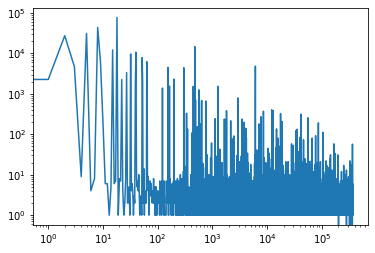

In [244]:
in_degrees['count'].plot(loglog=True)

In [234]:
out_degrees = pd.DataFrame.from_dict(out_degrees)
out_degrees.columns = ['send_address','count']

<AxesSubplot:>

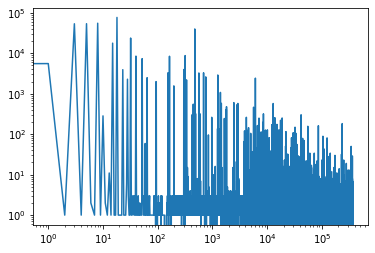

In [249]:
out_degrees['count'].plot(loglog=True)

## Look at transaction volumne and amounts per block

In [315]:
blocks=data.groupby(['block_height']).agg(transaction_vol=('tx_hash','count'),amount=('amount','sum'),fee=('fee','sum'),year=('Y','sum'))

In [318]:
blocks['year'] = blocks['year']/blocks['transaction_vol']

<AxesSubplot:xlabel='block_height'>

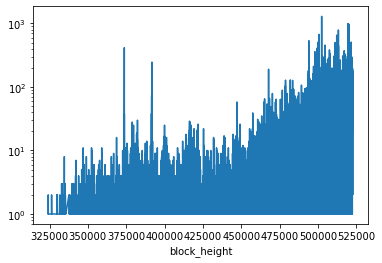

In [330]:
blocks.transaction_vol.plot(logy=True)

<AxesSubplot:xlabel='block_height'>

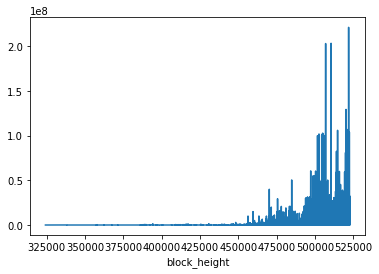

In [333]:
blocks.amount.plot()

<AxesSubplot:xlabel='block_height'>

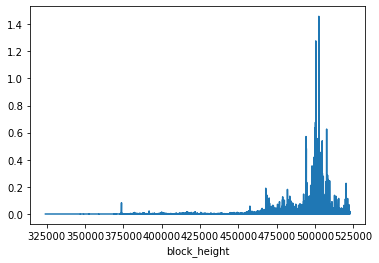

In [334]:
blocks.fee.plot()

In [327]:
blocks.corr()

,transaction_vol,amount,fee,year
transaction_vol,1.000000,0.329450,0.563667,0.414298
amount,0.329450,1.000000,0.195686,0.202304
fee,0.563667,0.195686,1.000000,0.201977
year,0.414298,0.202304,0.201977,1.000000


Transaction volume as well as amount per transaction sent has increased over time. There is also some correlation between transaction volume and the sum of fees per transaction that was charged.

## Estimating wallet size from receiving transactions

In [342]:
received = data.groupby('reference_address')['amount'].sum().reset_index()

In [343]:
sent = data.groupby('sending_address')['amount'].sum().reset_index()

In [346]:
received.rename({'reference_address':'address','amount':'received'},axis=1,inplace=True)
sent.rename({'sending_address':'address','amount':'sent'},axis=1,inplace=True)

In [349]:
trans_amounts = received.merge(sent)

In [353]:
trans_amounts['wallet_size'] = trans_amounts.received-trans_amounts.sent

### Top 10 wallets with more outgoings than incoming coins

In [368]:
trans_amounts.sort_values(by='wallet_size')[:10]

,address,received,sent,wallet_size
305124,Tether treasury,5.109928e+08,2.075033e+09,-1.564040e+09
293414,3BbDtxBSjgfTRxaBUgR2JACWRukLKtZdiQ,2.808872e+07,7.001371e+08,-6.720484e+08
68515,17ScKNXo4cL8DyfWfcCWu1uJySQuJm7iKC,1.000000e+01,9.010506e+07,-9.010505e+07
141114,1DGUWy6N6iHTpussbSP8XrK96tZgDboiWK,5.121772e+04,5.334380e+07,-5.329258e+07
280989,1gJ4FX7n4Udk1LVUSnutAgznyG9JZdQEU,3.171503e+07,7.491844e+07,-4.320341e+07
9877,12hnbu1xVuYF4VhaXYFyw6Pq2eudj3CG4g,1.531729e+06,9.977392e+06,-8.445663e+06
21171,13coLgY8DpWH7yjunMwyUgjEZQQbrAYT59,1.327500e+05,2.351433e+06,-2.218683e+06
289433,377UotoWsGk7K2Sx2QCnSVRBhCEZLtQtE4,3.128070e+06,4.628069e+06,-1.499999e+06
256994,1Nf3oM2pmoKx7M5oNUhyKYr3GLecineMHX,2.778268e+06,4.029768e+06,-1.251500e+06
239293,1MDVUq9wSSjrrZioy8ajB6Akz8umBnfbGi,1.100000e+02,8.671120e+05,-8.670020e+05


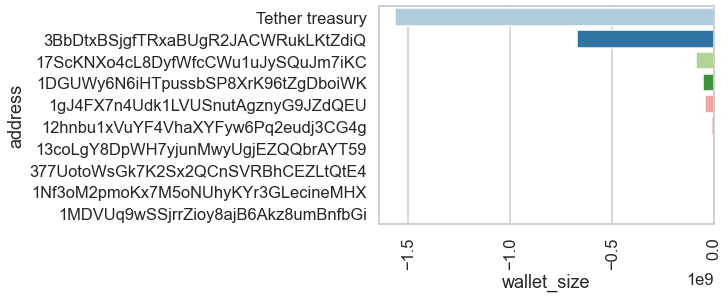

In [395]:
sns.set_style("whitegrid")
sns.set_palette("Paired")

sns.barplot(x="wallet_size", 
            y="address",
            data=trans_amounts.sort_values(by='wallet_size')[:10])
plt.xticks(rotation=90)
plt.show()

Unsurprisingly, tether treasury is the top wallet sending more than receiving. We could infer that the next highest net exporter is also a treasury wallet.

In [362]:
trans_amounts.sort_values(by='wallet_size',ascending=False)[:10]

,address,received,sent,wallet_size
305119,Binance,3.479279e+09,2.817714e+09,6.615646e+08
305121,Huobi.com-2,1.395183e+09,1.168431e+09,2.267526e+08
143730,1DUb2YYbQA1jjaNYzVXLZ7ZioEhLXtbUru,3.557034e+09,3.339889e+09,2.171449e+08
52256,168o1kqNquEJeR9vosUB5fw4eAwcVAgh8P,2.728707e+09,2.516524e+09,2.121824e+08
305120,Bitfinex,8.294645e+09,8.228053e+09,6.659221e+07
226312,1LAnF8h3qMGx3TSwNUHVneBZUEpwE4gu3D,4.180477e+09,4.124798e+09,5.567925e+07
103956,1AHeqzQ9VJXAuQu9tTmNqeeo1xgKzFSrTR,3.125246e+08,2.738399e+08,3.868476e+07
289777,37Tm3Qz8Zw2VJrheUUhArDAoq58S6YrS3g,8.001810e+07,5.435536e+07,2.566274e+07
204370,1JP22bCZVoWdbTZ93BqYAyit6YtdseRw9H,1.569320e+08,1.447000e+08,1.223203e+07
305122,Kraken,3.956977e+08,3.847764e+08,1.092135e+07


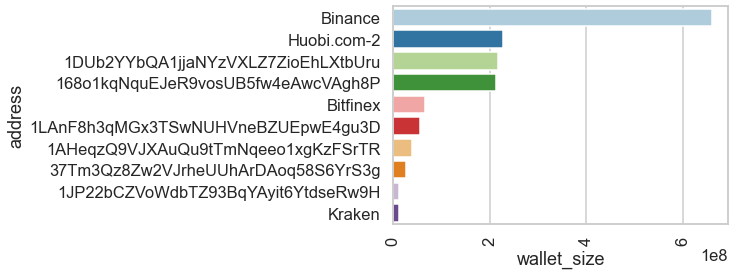

In [396]:
sns.barplot(x="wallet_size", 
            y="address",
            data=trans_amounts.sort_values(by='wallet_size',ascending=False)[:10])
plt.xticks(rotation=90)
plt.show()

In the top 10 positive wallet balances we have got 4 exchanges. We could assume the others are also from exchanges such as Bittrex and potentially Coinbase. To be sure we need to investigate a bit more.